In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.optimizers import SGD
from keras.models import load_model
from keras import regularizers
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.decomposition import PCA
%matplotlib inline


D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
df = pd.read_csv('C:/Users/99722/Desktop/ML/data.csv')

In [3]:
train_df = df[pd.to_datetime(df['quarter'])<="2019-01-01"]
test_df = df[pd.to_datetime(df['quarter'])=="2019-04-01"]

In [4]:
train_features=train_df.copy()
test_features=test_df.copy()
train_mret=train_features[['mret_net_weighted_qt_L1','mret_net_weighted_qt_L2','mret_net_weighted_qt_L3','mret_net_weighted_qt_L4']]
test_mret=test_features[['mret_net_weighted_qt_L1','mret_net_weighted_qt_L2','mret_net_weighted_qt_L3','mret_net_weighted_qt_L4']]
train_dum=train_features[['ioc_1','ioc_2','ioc_3','ioc_4','ioc_5','ioc_6','retail_fund_i','inst_fund_i',
                    'dead_flag_L1_i','lipper_asset_cd_1','lipper_asset_cd_2','lipper_asset_cd_3']]
test_dum=test_features[['ioc_1','ioc_2','ioc_3','ioc_4','ioc_5','ioc_6','retail_fund_i','inst_fund_i',
                    'dead_flag_L1_i','lipper_asset_cd_1','lipper_asset_cd_2','lipper_asset_cd_3']]
train_labels = train_features.pop('weight')
test_labels = test_features.pop('weight')
train_features.drop(['ioc_1','ioc_2','ioc_3','ioc_4','ioc_5','ioc_6','retail_fund_i','inst_fund_i',
                    'dead_flag_L1_i','lipper_asset_cd_1','lipper_asset_cd_2','lipper_asset_cd_3','quarter',
                     'mret_net_weighted_qt_L1','mret_net_weighted_qt_L2','mret_net_weighted_qt_L3','mret_net_weighted_qt_L4'],axis=1,inplace=True)
test_features.drop(['ioc_1','ioc_2','ioc_3','ioc_4','ioc_5','ioc_6','retail_fund_i','inst_fund_i',
                    'dead_flag_L1_i','lipper_asset_cd_1','lipper_asset_cd_2','lipper_asset_cd_3','quarter',
                   'mret_net_weighted_qt_L1','mret_net_weighted_qt_L2','mret_net_weighted_qt_L3','mret_net_weighted_qt_L4'],axis=1,inplace=True)

In [5]:
train_features=np.array(train_features)
test_features=np.array(test_features)
train_labels=np.array(train_labels)
test_labels=np.array(test_labels)
train_mret=np.array(train_mret)
test_mret=np.array(test_mret)
train_dum=np.array(train_dum)
test_dum=np.array(test_dum)

In [6]:
#Split Data for Test and Training
X_train = train_features
Xexog_train = train_mret
Xdum_train = train_dum
Y_train = train_labels

X_test = test_features
Xexog_test = test_mret
Xdum_test = test_dum
Y_test = test_labels

#Scale the predictors for training
Xscaler_train =  MinMaxScaler(feature_range=(-1,1))
X_scaled_train = Xscaler_train.fit_transform(X_train)

Xexog_scaler_train =  MinMaxScaler(feature_range=(-1,1))
Xexog_scaled_train = Xexog_scaler_train.fit_transform(Xexog_train)

# Scale the data for testing using the in-sample transformation from earlier
X_scaled_test = Xscaler_train.transform(X_test)
Xexog_scaled_test = Xexog_scaler_train.transform(Xexog_test)

10
[0.17520728 0.2765309  0.37106169 0.44411807 0.508157   0.56744595
 0.61318463 0.65580052 0.69681704 0.73117879 0.76210615 0.79137655
 0.81657032 0.83760208 0.85719204 0.87629784 0.89144233 0.90580182
 0.91857496 0.93034575 0.94119833 0.95086684 0.96006118 0.96846541
 0.97672623 0.98439383 0.99028619 0.99507793 0.99843655 0.99921984
 0.99986655 0.99995779 1.        ]


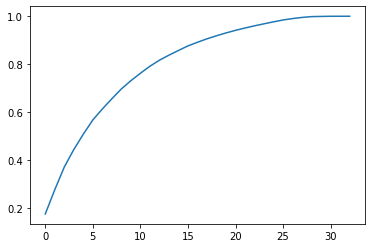

In [7]:
#  Get the number, d,  of PCA needed to explain 95% of the variance

pca = PCA()
pca.fit(X_scaled_train)
sumv = np.cumsum(pca.explained_variance_ratio_) # a vector of cumulative sums of the elements  

d = np.argmax(sumv >= 0.7) + 1

print(d)

print(sumv)
plt.plot(sumv)

In [8]:
pca_train = PCA(n_components = 10)
F_train=pca_train.fit_transform(X_scaled_train)

8
[0.20031062 0.32941859 0.43986941 0.51786201 0.58325868 0.64360807
 0.68952603 0.73235822 0.77040615 0.79693798 0.82257632 0.84143103
 0.8600496  0.87652494 0.89254949 0.90668597 0.92033106 0.93145209
 0.94136074 0.95073633 0.95971264 0.96835656 0.97529476 0.98142573
 0.98698427 0.99157195 0.99501492 0.99729696 0.99853511 0.99927323
 0.99991304 0.99996369 1.        ]


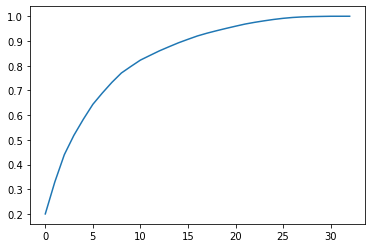

In [9]:
pca = PCA()
pca.fit(X_scaled_test)
sumv = np.cumsum(pca.explained_variance_ratio_) # a vector of cumulative sums of the elements  

d = np.argmax(sumv >= 0.7) + 1

print(d)

print(sumv)
plt.plot(sumv)

In [10]:
pca_test = PCA(n_components = 10)
F_test=pca_test.fit_transform(X_scaled_test)

In [11]:
archi = [32, 16, 8]
dropout_u = 0.3



# Keras requires 3D tuples for training.
F_train_expand = np.expand_dims(F_train, axis=1)
Xexog_scaled_train_expand = np.expand_dims(Xexog_scaled_train, axis=1)
Xdum_train_expand = np.expand_dims(Xdum_train, axis=1)

Y_train_expand1 = np.expand_dims(Y_train, axis=1)
Y_train_expand2 = np.expand_dims(Y_train_expand1, axis=1)

Y_test_expand1 = np.expand_dims(Y_test, axis=1)
Y_test_expand2 = np.expand_dims(Y_test_expand1, axis=1)

# seed numpy and tf
tf.set_random_seed(123)
np.random.seed(123)


# Define Model Architecture

# Base model for macro variables
n = len(archi)
layers = dict()
for i in range(n+1):
    if i == 0:
        layers['ins_main'] = Input(shape=(1,F_train_expand.shape[2]))
    elif i == 1:
        layers['dropout'+str(i)] = Dropout(dropout_u)(layers['ins_main'])
        layers['hidden'+str(i)] = Dense(archi[i-1],kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.001),bias_initializer='he_normal', 
                                        kernel_initializer='he_normal', activation='relu')(layers['dropout'+str(i)])
    elif i > 1 & i <= n:
        layers['dropout'+str(i)] = Dropout(dropout_u)(layers['hidden'+str(i-1)])
        layers['hidden'+str(i)] = Dense(archi[i-1],kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.001),bias_initializer='he_normal', 
                                        kernel_initializer='he_normal', activation='relu')(layers['dropout'+str(i)])

# Model for yield variables
layers['ins_exog'] = Input(shape=(1,Xexog_scaled_train_expand.shape[2]))

# Model for dummy variables
layers['ins_dum'] = Input(shape=(1,Xdum_train_expand.shape[2]))

# Merge macro / yield networks
layers['merge'] = concatenate([layers['hidden'+str(n)], layers['ins_exog'],layers['ins_dum'] ])
layers['dropout_final'] = Dropout(dropout_u)(layers['merge'])
layers['BN'] = BatchNormalization()(layers['dropout_final'])
layers['output'] = Dense(Y_train_expand2.shape[2],bias_initializer='he_normal',
                         kernel_initializer='he_normal')(layers['BN'])

model = Model(inputs=[layers['ins_main'], layers['ins_exog'],layers['ins_dum']], outputs=layers['output'])

# Compile model
sgd_fine = SGD(lr=0.01, momentum=0.9, decay=0.01, nesterov=True)
earlystopping = EarlyStopping(monitor='val_loss',min_delta=1e-6,
                              patience=20,verbose=0, mode='auto')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 10)        0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 10)        0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 32)        352         dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1, 32)        0           dense_1[0][0]                    
____________________________________________________________________________________________

In [12]:
model.compile(loss='mean_squared_error', optimizer=sgd_fine)
history=model.fit([F_train_expand, Xexog_scaled_train_expand, Xdum_train_expand], Y_train_expand2, epochs=300,
                  validation_split=0.15, batch_size=32, shuffle=True, verbose=1)

# Scale the data for testing using the in-sample transformation from earlier
F_test_expand = np.expand_dims(F_test, axis=1)
Xexog_scaled_test_expand = np.expand_dims(Xexog_scaled_test, axis=1)
Xdum_test_expand = np.expand_dims(Xdum_test, axis=1)


# Make out-of-sample prediction on the unseen observations
Ypred = model.predict([F_test_expand,Xexog_scaled_test_expand,Xdum_test_expand])
Ypred = np.squeeze(Ypred,axis=1)

score = model.evaluate([F_test_expand,Xexog_scaled_test_expand,Xdum_test_expand], Y_test_expand2, verbose=1)
print("Test score:", score)



Train on 17203 samples, validate on 3036 samples
Epoch 1/300
17203/17203 [==============================] - 1s 57us/step - loss: 3.5290 - val_loss: 2.9000
Epoch 2/300
17203/17203 [==============================] - 1s 43us/step - loss: 2.8019 - val_loss: 2.5895
Epoch 3/300
17203/17203 [==============================] - 1s 41us/step - loss: 2.5775 - val_loss: 2.4109
Epoch 4/300
17203/17203 [==============================] - 1s 43us/step - loss: 2.4572 - val_loss: 2.3231
Epoch 5/300
17203/17203 [==============================] - 1s 41us/step - loss: 2.3717 - val_loss: 2.2651
Epoch 6/300
17203/17203 [==============================] - 1s 45us/step - loss: 2.3137 - val_loss: 2.1903
Epoch 7/300
17203/17203 [==============================] - 1s 46us/step - loss: 2.2646 - val_loss: 2.1639
Epoch 8/300
17203/17203 [==============================] - 1s 42us/step - loss: 2.2308 - val_loss: 2.1440
Epoch 9/300
17203/17203 [==============================] - 1s 44us/step - loss: 2.2005 - val_loss: 2.0

17203/17203 [==============================] - 1s 44us/step - loss: 1.8940 - val_loss: 1.8049
Epoch 76/300
17203/17203 [==============================] - 1s 46us/step - loss: 1.8958 - val_loss: 1.8168
Epoch 77/300
17203/17203 [==============================] - 1s 50us/step - loss: 1.8949 - val_loss: 1.8016
Epoch 78/300
17203/17203 [==============================] - 1s 46us/step - loss: 1.8955 - val_loss: 1.8104
Epoch 79/300
17203/17203 [==============================] - 1s 47us/step - loss: 1.8881 - val_loss: 1.8006
Epoch 80/300
17203/17203 [==============================] - 1s 46us/step - loss: 1.8931 - val_loss: 1.8008
Epoch 81/300
17203/17203 [==============================] - 1s 45us/step - loss: 1.8896 - val_loss: 1.8008
Epoch 82/300
17203/17203 [==============================] - 1s 41us/step - loss: 1.8930 - val_loss: 1.7969
Epoch 83/300
17203/17203 [==============================] - 1s 35us/step - loss: 1.8919 - val_loss: 1.8067
Epoch 84/300
17203/17203 [========================

17203/17203 [==============================] - 1s 34us/step - loss: 1.8560 - val_loss: 1.7654
Epoch 152/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8531 - val_loss: 1.7762
Epoch 153/300
17203/17203 [==============================] - 1s 35us/step - loss: 1.8522 - val_loss: 1.7627
Epoch 154/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8531 - val_loss: 1.7619
Epoch 155/300
17203/17203 [==============================] - 1s 35us/step - loss: 1.8500 - val_loss: 1.7606
Epoch 156/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8535 - val_loss: 1.7660
Epoch 157/300
17203/17203 [==============================] - 1s 39us/step - loss: 1.8484 - val_loss: 1.7651
Epoch 158/300
17203/17203 [==============================] - 1s 36us/step - loss: 1.8516 - val_loss: 1.7647
Epoch 159/300
17203/17203 [==============================] - 1s 37us/step - loss: 1.8495 - val_loss: 1.7719
Epoch 160/300
17203/17203 [===============

Epoch 227/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8337 - val_loss: 1.7517
Epoch 228/300
17203/17203 [==============================] - 1s 39us/step - loss: 1.8399 - val_loss: 1.7541
Epoch 229/300
17203/17203 [==============================] - 1s 35us/step - loss: 1.8374 - val_loss: 1.7460
Epoch 230/300
17203/17203 [==============================] - 1s 36us/step - loss: 1.8349 - val_loss: 1.7462
Epoch 231/300
17203/17203 [==============================] - 1s 37us/step - loss: 1.8386 - val_loss: 1.7453
Epoch 232/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8347 - val_loss: 1.7519
Epoch 233/300
17203/17203 [==============================] - 1s 38us/step - loss: 1.8318 - val_loss: 1.7582
Epoch 234/300
17203/17203 [==============================] - 1s 37us/step - loss: 1.8377 - val_loss: 1.7517
Epoch 235/300
17203/17203 [==============================] - 1s 36us/step - loss: 1.8346 - val_loss: 1.7486
Epoch 236/300
17203/17203 [=